In [1]:
import import_ipynb

import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline

from eunjeon import Mecab; mecab = Mecab()
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# 맷플롯립 그래프 한글폰트깨짐 방지
import matplotlib as mpl
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

# 데이터프레임 출력시 잘림현상 해결
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

# 경고 제거
import warnings
warnings.filterwarnings(action='ignore')

### 사용되는 함수 목록

In [2]:
# 데이터프레임에서 명사만 추출, 한글자 단어 제거, 불용어 제거하는 함수
def text_process(contents):
    # 불용어 목록 가져오기
    file = open('./dataset/stopwords.txt', 'r', encoding='UTF8')
    STOPWORDS = file.read().split(', ')
    file.close()
    
    # 30회 초과 단어목록 가져오기
    file = open('./dataset/gongju/min30.txt', 'r', encoding='utf-8')
    MINWORDS = file.read().split(',')
    file.close()
    
    # Dataframe title, content를 리스트로 변환
    content_list = [content for content in contents]
    
    # 리스트 -> 문자열로 변환
    content_text = ''.join(content_list)
    
    # 형태소분석 -> 명사만 추출
    noun_list = mecab.nouns(content_text)
    
    # 한글자 단어 제거
    noun_list = [x for x in noun_list if len(x)>=2]
    
    # 충남->충청남도, 공주->공주시 통합
    for i in range(len(noun_list)):
        if(noun_list[i]=='충남'):
            noun_list[i] = '충청남도'
        if(noun_list[i]=='공주'):
            noun_list[i] = '공주시'
        
    # 30회 초과 단어만 채택
    noun_list = [word for word in noun_list if word in MINWORDS]
        
    # 불용어 제거 후 반환
    return ' '.join([word for word in noun_list if word not in STOPWORDS])

In [3]:
# TF-IDF를 통해 문서의 핵심어를 랭킹순으로 추출 -> 리스트로 반환
def getRankListFromSeries(s):
    clean_list = s.to_list()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_list)

    terms = tfidf_vectorizer.get_feature_names()

    # TF-IDF 각 단어의 결과를 더함
    sums = tfidf_matrix.sum(axis=0)

    # 단어와 결과를 연결
    data = []
    for idx, term in enumerate(terms):
           data.append( (term, sums[0, idx] ))

    # 데이터프레임으로 변환, 내림차순 정렬 
    ranking_df = pd.DataFrame(data, columns=['term','rank'])
    ranking_df.sort_values('rank',inplace=True, ascending=False)
    
    # 리스트로 반환
    return tolist(ranking_df)

In [4]:
# 데이터프레임 -> 리스트로 변환
def tolist(df):
    return [tuple(r) for r in df.to_numpy()]

----------------------------------------------------------------------------------------

### 판다스로 네이버블로그 데이터셋 불러오기

In [5]:
data_df = pd.read_excel("./dataset/gongju/naverview_gongju.xlsx", engine="openpyxl")
data_df.head()

,title,nickname,datetime,content
0,유구한 세월의 발자취 - 공주시 유구터미널,모리노\n(goyasoul88),2008. 10. 1. 2:19,석남리\n충청남도 > 공주시 > 유구읍\n기간 2008.9.21 ~ 2008.9.2...
1,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘,오동균\n(odk1956),2006. 3. 21. 22:59,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘\n 함께하면 풍성해지는 40일 캠...
2,공주시 산림박물관 견학,하이데스\n(pygmalion999),2007. 12. 27. 15:06,산림박물관이 있는줄 얼마전에 알았다..\n어떤것이 전시되어 있는지 궁금하기도 하...
3,찬란한 백제문화를 꽃피운 공주시가와 금강줄기가 산아래 내려다 보이는,청람\n(khrnice),2006. 9. 11. 21:16,이제 완연한 가을 날씨다..\n좀처럼 한 곳에 머물기를 죽도록 싫어하는 성격이 이렇...
4,충남 기도터-충남 공주시 사곡면 벽계산 약수암 기도터,찬누리\n(jinsug9339),2007. 3. 7. 20:54,충남 공주시 사곡면 벽계산 약수암 기도터\n(위)-벽계산 약수암 기도터 주차장과 요...


### 데이터프레임의 title, content를 클렌징후 clean_title, clean_content 칼럼에 저장

In [6]:
data_df['title'] = data_df['title'].astype('str')
data_df['content'] = data_df['content'].astype('str')

In [7]:
data_df['clean_title'] = data_df.title.apply(text_process)
data_df['clean_content'] = data_df['clean_title'] + " " + data_df.content.apply(text_process)

In [8]:
data_df.head()

,title,nickname,datetime,content,clean_title,clean_content
0,유구한 세월의 발자취 - 공주시 유구터미널,모리노\n(goyasoul88),2008. 10. 1. 2:19,석남리\n충청남도 > 공주시 > 유구읍\n기간 2008.9.21 ~ 2008.9.2...,세월 발자취 공주시 유구 터미널,세월 발자취 공주시 유구 터미널 충청남도 공주시 유구읍 기간 컨셉 사진 여행 경로 ...
1,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘,오동균\n(odk1956),2006. 3. 21. 22:59,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘\n 함께하면 풍성해지는 40일 캠...,공주시 교회 프로젝트 사회 감동,공주시 교회 프로젝트 사회 감동 공주시 교회 프로젝트 사회 감동 캠페인 전개 공주시...
2,공주시 산림박물관 견학,하이데스\n(pygmalion999),2007. 12. 27. 15:06,산림박물관이 있는줄 얼마전에 알았다..\n어떤것이 전시되어 있는지 궁금하기도 하...,공주시 산림 박물관 견학,공주시 산림 박물관 견학 산림 박물관 전시 자연환경 견학 공주시 금강 자연 휴양림 ...
3,찬란한 백제문화를 꽃피운 공주시가와 금강줄기가 산아래 내려다 보이는,청람\n(khrnice),2006. 9. 11. 21:16,이제 완연한 가을 날씨다..\n좀처럼 한 곳에 머물기를 죽도록 싫어하는 성격이 이렇...,백제 문화 공주시 시가 금강 줄기,백제 문화 공주시 시가 금강 줄기 가을 날씨 성격 오후 한참 공주시 궁중 칼국수 아...
4,충남 기도터-충남 공주시 사곡면 벽계산 약수암 기도터,찬누리\n(jinsug9339),2007. 3. 7. 20:54,충남 공주시 사곡면 벽계산 약수암 기도터\n(위)-벽계산 약수암 기도터 주차장과 요...,충청남도 충청남도 공주시 사곡면 계산,충청남도 충청남도 공주시 사곡면 계산 충청남도 공주시 사곡면 계산 계산 주차장 요사...


### Word2Vec를 이용해 단어-벡터 생성

In [9]:
# 명사 목록 가져오기
content_noun_list = []

for i in range(len(data_df)):
    content_noun_list.append(data_df['clean_content'][i])

# string형으로 변환
content_str = ' '.join([word for word in content_noun_list]).split()

In [10]:
# 학습
model = Word2Vec([content_str], vector_size=300, window=10, min_count=30, workers=4, sg=1, epochs=20)

In [11]:
word_list = [word[0] for word in getRankListFromSeries(data_df['clean_content'])[:100]] #tf-idf

In [12]:
# 단어와 벡터값 연결
my_dict = dict({})

for idx, key in enumerate(word_list):
    my_dict[key] = model.wv[key]

In [13]:
# 데이터프레임으로 만들기
wordvectors_df = pd.DataFrame(my_dict).transpose()
wordvectors_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
공주시,-0.181343,0.165556,0.322387,-0.021055,0.011673,0.003838,0.203546,0.238981,-0.105216,-0.008705,0.043739,-0.128066,0.017274,0.266165,-0.325362,-0.115545,-0.068801,-0.254477,-0.119438,-0.217731,-0.124320,0.216549,0.263115,-0.032193,0.494189,0.011380,-0.202845,0.007644,-0.093513,-0.070599,-0.175099,0.016716,0.312766,0.035051,-0.107081,-0.008935,0.149849,-0.288730,-0.263618,-0.073366,-0.397351,0.102937,-0.194236,-0.143130,0.175400,-0.122447,0.053890,0.288348,-0.078968,0.281332,...,-0.086894,-0.186002,-0.037072,-0.129796,-0.160927,-0.218599,0.022227,-0.020364,-0.463854,0.005869,-0.109952,0.219201,0.005141,-0.296407,-0.221638,0.002723,0.141479,0.228428,-0.390193,-0.016220,0.308908,0.067276,0.172663,-0.348060,0.013094,-0.094026,0.257616,-0.019830,-0.249854,-0.289044,0.387425,-0.341271,-0.097916,0.123145,0.116751,-0.051103,-0.049020,-0.084625,-0.064957,0.003434,-0.193638,0.194141,0.216856,-0.081264,-0.114113,-0.040636,0.147168,-0.014078,0.237627,-0.050989
충청남도,-0.195282,0.165912,0.439760,-0.071992,0.043928,0.040207,0.306264,0.406780,-0.100273,-0.010192,0.032880,-0.211995,0.057400,0.178266,-0.233054,-0.129688,-0.157986,-0.256265,-0.014194,-0.030900,-0.148555,0.156101,0.141136,0.340686,0.164707,0.185486,-0.076883,-0.032332,-0.150205,-0.061461,-0.296615,0.142126,0.067038,-0.101592,-0.161896,-0.076202,0.401985,-0.274987,-0.151516,0.089918,-0.246956,0.206438,-0.137864,-0.135516,0.152306,-0.150827,-0.123881,0.126776,-0.001739,0.225722,...,0.127855,-0.119851,0.007792,0.003529,0.040059,0.004869,0.020255,-0.265485,-0.369840,-0.162937,0.097656,0.122228,0.068462,-0.306638,-0.033655,-0.014527,0.067035,0.289150,-0.342680,-0.058035,0.284272,0.100554,0.092023,-0.061284,0.009963,-0.204807,0.279827,-0.077182,-0.300480,-0.281274,0.241809,-0.191262,-0.209460,-0.062988,-0.101763,0.007571,-0.004864,-0.068014,-0.037811,0.058013,-0.130047,0.238132,0.275393,-0.124135,-0.023242,0.068546,0.281675,-0.177047,0.264994,0.008077
사업,-0.155122,0.019421,0.497276,0.048367,0.069514,0.104607,0.302978,0.119462,0.200457,-0.004320,-0.002435,-0.348435,0.011792,0.375802,-0.281657,0.038843,-0.034831,-0.078464,0.243022,-0.406927,-0.037591,0.153784,0.340163,0.042098,0.382499,-0.165902,-0.321940,0.005559,-0.065189,-0.306765,0.243483,-0.045469,0.317585,0.300924,-0.289567,-0.272160,0.024961,-0.601291,-0.106948,0.026465,-0.146120,0.050877,-0.081646,-0.349965,0.308896,0.119016,0.055631,0.438044,-0.312405,0.096256,...,-0.204490,0.127484,0.054879,-0.046790,-0.562476,-0.470469,0.289728,0.036341,-0.328476,-0.002144,-0.192312,0.110729,0.188089,-0.459805,-0.480670,-0.054640,0.042903,0.296430,-0.410661,0.089460,0.228616,0.071295,0.314009,-0.399296,-0.116890,-0.182914,-0.059173,-0.259903,-0.283419,-0.354226,0.437489,-0.306416,-0.196339,0.394902,0.226269,-0.357887,-0.104502,-0.224162,0.236997,0.180382,-0.234127,0.489570,0.239773,0.058113,-0.008212,0.238688,0.085593,0.187719,0.376007,-0.161483
문화,-0.310152,-0.021994,0.370839,-0.196242,0.033018,-0.025692,0.079611,0.056223,-0.006196,0.047856,-0.047464,-0.306858,0.023309,0.202590,-0.001387,-0.126702,0.057638,-0.342302,0.111537,-0.138078,0.166566,-0.073328,0.158807,-0.011573,0.214440,-0.141428,-0.185344,0.161793,-0.232689,-0.085304,0.004020,-0.097403,0.206246,0.140495,-0.072053,-0.058535,0.229931,-0.239539,-0.124055,0.081926,-0.124873,0.203344,-0.270788,0.004630,0.074579,0.113957,0.235578,0.475601,-0.185006,0.187876,...,-0.182512,-0.237705,0.347928,0.019622,-0.173225,-0.315909,0.200350,0.041439,-0.357503,0.178787,-0.136571,0.102618,0.183710,-0.341068,-0.228552,-0.128676,0.168735,0.149872,-0.305827,-0.288004,-0.030966,-0.018207,-0.007809,-0.206093,0.029462,0.010958,0.273609,-0.019060,-0.273619,-0.459918,0.0

### 단어간 코사인 유사도 계산

In [14]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b)))

In [15]:
count_dict = {}

for i in tqdm(range(len(wordvectors_df))):
    for j in range(i+1, len(wordvectors_df)):
        cossim = cosine_similarity(wordvectors_df.iloc[i, :].values, wordvectors_df.iloc[j, :].values)
        count_dict[wordvectors_df.iloc[i, :].name, wordvectors_df.iloc[j, :].name] = cossim

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 65.56it/s]


In [16]:
count_dict

{('공주시', '충청남도'): 0.7454554,
 ('공주시', '사업'): 0.694697,
 ('공주시', '문화'): 0.6102813,
 ('공주시', '시민'): 0.67115223,
 ('공주시', '도시'): 0.6516665,
 ('공주시', '체험'): 0.61359656,
 ('공주시', '마을'): 0.56504524,
 ('공주시', '사진'): 0.72242755,
 ('공주시', '교육'): 0.64682966,
 ('공주시', '백제'): 0.44593003,
 ('공주시', '토지'): 0.63411415,
 ('공주시', '시장'): 0.711472,
 ('공주시', '행사'): 0.6750238,
 ('공주시', '행정'): 0.6124953,
 ('공주시', '주택'): 0.54480475,
 ('공주시', '계룡산'): 0.6430841,
 ('공주시', '계획'): 0.6589385,
 ('공주시', '공산'): 0.5790213,
 ('공주시', '카페'): 0.085044734,
 ('공주시', '수도'): 0.7738604,
 ('공주시', '안전'): 0.5757639,
 ('공주시', '마곡사'): 0.7218463,
 ('공주시', '축제'): 0.62278724,
 ('공주시', '맛집'): 0.048873026,
 ('공주시', '대전'): 0.7234163,
 ('공주시', '주민'): 0.5236727,
 ('공주시', '금강'): 0.5834246,
 ('공주시', '공원'): 0.72084653,
 ('공주시', '활동'): 0.6039026,
 ('공주시', '관광'): 0.57876444,
 ('공주시', '갑사'): 0.4523434,
 ('공주시', '박물관'): 0.4933561,
 ('공주시', '기자'): 0.84067446,
 ('공주시', '관리'): 0.5906108,
 ('공주시', '복지'): 0.6305981,
 ('공주시', '참여'): 0.614594,
 ('공주시', '

### 저장

In [17]:
# 딕셔너리를 리스트로 변환
count_list = []

# count_list에 단어1, 단어2, 코사인유사도 형태로 저장
for row in count_dict:
    count_list.append([row[0], row[1], count_dict[row]])

In [18]:
# DataFrame 형식으로 만든다.
sim_df = pd.DataFrame(count_list, columns=['word1', 'word2', 'cos_sim'])
sim_df = sim_df.sort_values(by=['cos_sim'], ascending=False)
sim_df = sim_df.reset_index(drop=True)

# 단어쌍 결과를 csv로 저장
sim_df.to_csv('./dataset/gongju/graph_cosine_similarity.csv', encoding='euc-kr')
sim_df.head()

,word1,word2,cos_sim
0,아파트,민원,0.967926
1,복지,사회,0.951895
2,개발,가능,0.951862
3,사용,아파트,0.947903
4,사용,자전거,0.947022


# Graph Clustering

In [19]:
import operator

# 그래프
import networkx as nx
import community as community_louvain

# 시각화
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 폰트설정, 한글깨짐방지
fm._rebuild()
font_fname = 'C:/Windows/Fonts/malgun.ttf'
fontprop = fm.FontProperties(fname=font_fname).get_name()

In [20]:
cossim_df = pd.read_csv('./dataset/gongju/graph_cosine_similarity.csv', encoding='euc-kr')
org_cossim_df = cossim_df.copy()

cossim_df['cos_sim'] = org_cossim_df['cos_sim']
cossim_df = cossim_df.dropna()
cossim_df.head()

,Unnamed: 0,word1,word2,cos_sim
0,0,아파트,민원,0.967926
1,1,복지,사회,0.951895
2,2,개발,가능,0.951862
3,3,사용,아파트,0.947903
4,4,사용,자전거,0.947022


100%|███████████████████████████████████████████████████████████████████████████| 1460/1460 [00:00<00:00, 18125.51it/s]


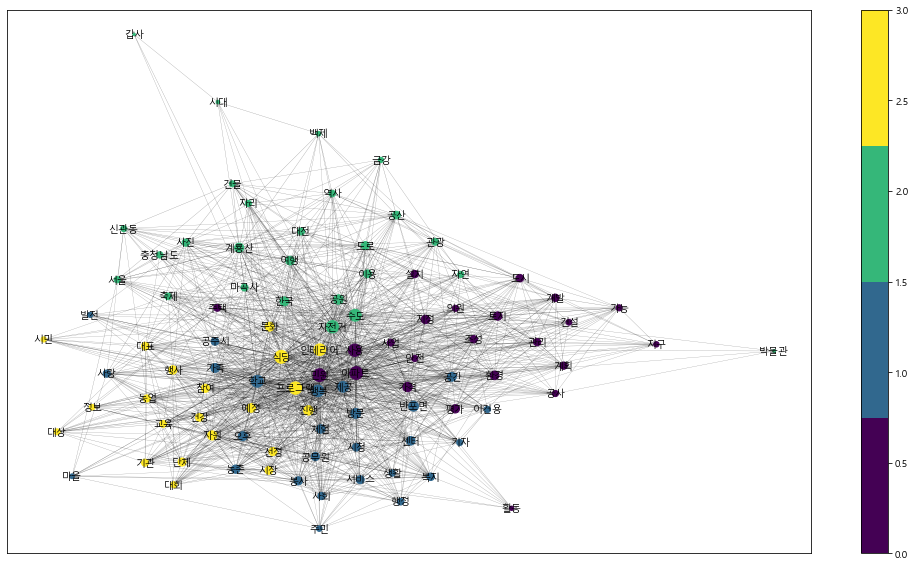

커뮤니티 1 
 ['아파트', '민원', '개발', '가능', '사용', '토지', '가격', '건설', '관리', '조성', '평가', '도시', '지정', '공사', '설치', '계획', '안전', '사업', '주택', '환경', '지구', '의원', '활동'] 

커뮤니티 2 
 ['복지', '사회', '서비스', '학교', '행복', '반포면', '공간', '가족', '제공', '체험', '기자', '이건용', '시청', '방문', '센터', '농촌', '사랑', '공주시', '오후', '공무원', '봉사', '주민', '행정', '마을', '생활', '발전'] 

커뮤니티 3 
 ['자전거', '수도', '공산', '금강', '계룡산', '건물', '도로', '여행', '사진', '축제', '이용', '한국', '공원', '대전', '자리', '백제', '역사', '자연', '관광', '신관동', '충청남도', '마곡사', '시대', '서울', '갑사', '박물관'] 

커뮤니티 4 
 ['식당', '프로그램', '인테리어', '자원', '건강', '선정', '교육', '단체', '기관', '대회', '행사', '진행', '농업', '문화', '참여', '정보', '시장', '대표', '대상', '예정', '시민'] 

노드 수 :  96


In [49]:
# Thershold 설정
threshold = 0.69

"""
차수(Degree) 계산
"""
# 그래프 생성
G = nx.Graph()

# 거리가 threshold 초과 단어쌍에 대해서만 edge 생성
for idx in tqdm(range((len(np.where(cossim_df['cos_sim'] >= threshold)[0])))):
    G.add_edge(cossim_df['word1'][idx], cossim_df['word2'][idx], weight=cossim_df['cos_sim'][idx])

# Degree Centrality 계산
dgr = nx.degree_centrality(G)

# 내림차순 정렬
sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)

# 노드생성, degree에 따라 노드 크기 결정
for idx in range(len(sorted_dgr)):
    G.add_node(sorted_dgr[idx][0], nodesize=sorted_dgr[idx][1])

"""
그래프 클러스터링 (louvain)
"""

# 클러스터(파티션) 계산
partition = community_louvain.best_partition(G, random_state=16)

# 레이아웃 설정
pos = nx.spring_layout(G)

# 클러스터(파티션)에 따른 색상 결정
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)

"""
그래프 시각화
"""
# 그래프 크기 설정
fig = plt.figure(figsize=(18,10))

# 노드 및 엣지크기 설정
sizes = [G.nodes[node]['nodesize'] * 200 for node in G] # 노드사이즈
edge_wts = [0.3 * edge[2] for edge in G.edges(data = 'weight')] # 엣지사이즈

# 그래프 시각화
im = nx.draw_networkx_nodes(G, pos, cmap=cmap, node_size=sizes, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5, width=edge_wts)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="BLACK", font_family=fontprop)
plt.colorbar(im)
plt.show(block=False)

# 커뮤니티 텍스트 출력
count = 0    
node_count = 0
nodes_list = []
strdata = ''
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    node_count = node_count + len(list_nodes)
    nodes_list.append(list_nodes)
    strdata = strdata + '\n커뮤니티' + str(int(count)) + '\n'

    for s in list_nodes:        
        strdata = strdata + s + " "

    print('커뮤니티', int(count), '\n',list_nodes, '\n')

print('노드 수 : ', node_count)